In [2]:
import pandas as pd

In [5]:
df_add = pd.read_csv('../data/preprocessed_test_for_train.csv')

In [6]:
df_add.shape

(2347, 614)

In [8]:
df = pd.read_csv('../data/preprocessed_train.csv')

In [9]:
df = pd.concat([df, df_add])

In [10]:
df['accuracy_group'].mean(), df['accuracy_group'].std()

(1.865448919498927, 1.266954301695134)

In [141]:
(X == np.inf).sum()[(X == np.inf).sum() != 0]

mean_time_per_day        8410
ratio_of_life_in_game    2918
sessions_per_day         8766
events_per_day           8766
dtype: int64

In [66]:
train_df.drop(columns=['accuracy_group']).values.shape

(17690, 589)

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df.drop(columns=['accuracy_group', 'installation_id']).fillna(0), train_df['accuracy_group'], test_size=0.2)

In [139]:
X = train_df

In [140]:
X['hour_sin'] = X['hour'].map(lambda x: np.sin(2 * np.pi * x / 23))
X['hour_cos'] = X['hour'].map(lambda x: np.cos(2 * np.pi * x / 23))
X = X.drop(columns=['hour'])

X['weekday_sin'] = X['weekday'].map(lambda x: np.sin(2 * np.pi * x / 6))
X['weekday_cos'] = X['weekday'].map(lambda x: np.cos(2 * np.pi * x / 6))
X = X.drop(columns=['weekday'])

X['day_sin'] = X['day'].map(lambda x: np.sin(2 * np.pi * x / 6))
X['day_cos'] = X['day'].map(lambda x: np.cos(2 * np.pi * x / 6))
X = X.drop(columns=['day'])

X['mean_time_per_day'] = X['total_time'] / X['days_since_installation']
X['current_title_mean_time'] = X['current_title_total_time'] / X['current_title_count']
X['current_world_mean_time'] = X['current_world_total_time'] / X['current_world_count']
X['last_mean_accuracy'] = X[['last_accuracy_Bird Measurer (Assessment)',
                             'last_accuracy_Cart Balancer (Assessment)',
                             'last_accuracy_Cauldron Filler (Assessment)',
                             'last_accuracy_Chest Sorter (Assessment)',
                             'last_accuracy_Mushroom Sorter (Assessment)']].mean(axis=1)
X['ratio_of_life_in_game'] = X['total_time'] / X['sec_since_installation']
X['time_per_session'] = X['total_time'] / X['accumulated_sessions']
X['sessions_per_day'] = X['accumulated_sessions'] / X['days_since_installation']
X['events_per_session'] = X['accumulated_actions'] / X['accumulated_sessions']
X['time_per_event'] = X['total_time'] / X['accumulated_actions']
X['events_per_day'] = X['accumulated_actions'] / X['days_since_installation']

cols_to_drop = [col for col in X.columns if ('event_id' in col)]

count_cols = [col for col in X.columns if 'count' in col]
for col in count_cols:
    X[col] = X[col] / X['accumulated_actions']

In [95]:
X = X.drop(columns=cols_to_drop + useless_event_feats).fillna(0)

In [134]:
ngb = NGBRegressor(learning_rate=0.1, verbose_eval=5, n_estimators=40).fit(X.replace({np.inf: 0}), Y_train)

[iter 0] loss=1.6491 val_loss=0.0000 scale=1.0000 norm=1.2257


KeyboardInterrupt: 

In [87]:
Y_preds = ngb.predict(X_train)
test_MSE = mean_squared_error(Y_preds, Y_train)
print('Test MSE', np.sqrt(test_MSE))

Test MSE 0.9850934537611421


In [88]:
Y_preds = ngb.predict(X_test)
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', np.sqrt(test_MSE))

Test MSE 1.0242779443152756


In [44]:
from ngboost import NGBRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X, Y = load_boston(True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

[iter 0] loss=3.6491 val_loss=0.0000 scale=0.5000 norm=3.3612
[iter 100] loss=3.0818 val_loss=0.0000 scale=1.0000 norm=3.7813
[iter 200] loss=2.4349 val_loss=0.0000 scale=2.0000 norm=4.0105
[iter 300] loss=2.0369 val_loss=0.0000 scale=2.0000 norm=3.1987
[iter 400] loss=1.8326 val_loss=0.0000 scale=2.0000 norm=2.8591
Test MSE 6.857203610165826


In [58]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(num_leaves=4, max_depth=4).fit(X_train, Y_train)
Y_preds = lgb.predict(X_test)

test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

Test MSE 13.244407747518137


In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import pickle
import models
import json

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow import keras

In [4]:
train_df = pd.read_csv('./data/preprocessed_train.csv')

In [15]:
last_df = train_df.groupby('installation_id').last().reset_index()

In [18]:
title_event_codes =[col for col in train_df.columns if 'title_event_code' in col]

In [26]:
n = last_df.shape[0]

In [28]:
doc_freq = (last_df[title_event_codes] != 0).sum()

In [34]:
idf = np.log((1 + n) / (1 + doc_freq)) + 1

In [42]:
train_df[title_event_codes] = train_df[title_event_codes] * idf

In [43]:
train_df.to_csv('./data/idf_preprocessed_train.csv', index=False)

In [526]:
train_df = train_df.fillna(0)

In [527]:
X = train_df.drop(columns=['accuracy_group', 'installation_id'])
y = train_df['accuracy_group']

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [529]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [551]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(.5))
          
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(.5))
          
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Dense(1, activation="linear"))

model.compile(loss="mse", optimizer=keras.optimizers.Adam(0.01), metrics=['mse'])

In [552]:
model.fit(X_train, y_train.values, epochs=100, batch_size=128, verbose=1, validation_data=(X_test, y_test.values))

Train on 14152 samples, validate on 3538 samples
Epoch 1/100
14152/14152 [==============================] - 2s 162us/sample - loss: 2.6143 - mse: 2.6143 - val_loss: 1.5234 - val_mse: 1.5234
Epoch 2/100
14152/14152 [==============================] - 1s 56us/sample - loss: 1.5906 - mse: 1.5906 - val_loss: 1.3993 - val_mse: 1.3993
Epoch 3/100
14152/14152 [==============================] - 1s 53us/sample - loss: 1.4923 - mse: 1.4923 - val_loss: 1.3513 - val_mse: 1.3513
Epoch 4/100
14152/14152 [==============================] - 1s 54us/sample - loss: 1.4203 - mse: 1.4203 - val_loss: 1.3308 - val_mse: 1.3308
Epoch 5/100
14152/14152 [==============================] - 1s 53us/sample - loss: 1.3956 - mse: 1.3956 - val_loss: 1.3428 - val_mse: 1.3428
Epoch 6/100
14152/14152 [==============================] - 1s 56us/sample - loss: 1.3848 - mse: 1.3848 - val_loss: 1.3143 - val_mse: 1.3143
Epoch 7/100
14152/14152 [==============================] - 1s 55us/sample - loss: 1.3524 - mse: 1.3524 - val_l

KeyboardInterrupt: 

In [425]:
train_df['accuracy_group']

0        3
1        0
2        3
3        2
4        3
        ..
17685    3
17686    3
17687    1
17688    0
17689    1
Name: accuracy_group, Length: 17690, dtype: int64

In [412]:
test_df[['last_accuracy_Bird Measurer (Assessment)',
                                 'last_accuracy_Cart Balancer (Assessment)',
                                 'last_accuracy_Cauldron Filler (Assessment)',
                                 'last_accuracy_Chest Sorter (Assessment)',
                                 'last_accuracy_Mushroom Sorter (Assessment)']].mean(axis=1)

0      1.000000
1      0.466667
2           NaN
3           NaN
4           NaN
         ...   
995    1.000000
996    1.000000
997    0.444444
998    0.000000
999    1.000000
Length: 1000, dtype: float64

In [401]:
test_df = pd.read_csv('./data/preprocessed_test.csv')

In [259]:
test_df = pd.read_csv('./data/test.csv')

In [279]:
lst = []

In [328]:
toys = []

In [329]:
for x in test_df['event_data'][test_df['event_data'].str.contains('"toy_earned":')]:
    try:
        toys.append(json.loads(x)['toy_earned'])
    except:
        pass

In [330]:
pd.value_counts(toys)

          507
ufo        90
ball       89
ship       86
rocket     79
duck       67
dtype: int64

In [286]:
for x in test_df['event_data']:
    dct = json.loads(x)

In [ ]:
tutorial_step

In [368]:
test_df['installation_id'].nunique()

1000

In [381]:
test_df['event_data'][test_df['event_data'].str.contains('blablabf')].map(lambda x: json.loads(x)).sum()

0

In [386]:
test_df.iloc[idx].shape

(682, 11)

In [396]:
test_df.iloc[idx].groupby('installation_id').count()['event_id'].value_counts()

1     174
2      75
3      34
4      20
6       7
7       5
5       4
12      2
11      2
10      2
13      1
Name: event_id, dtype: int64

In [393]:
test_df['event_data'][test_df['event_data'].str.contains('"tutorial_step"')].map(lambda x: int(json.loads(x)['tutorial_step']))

1146       6
1973       2
3017       2
7022       2
7316       2
          ..
1146877    2
1153204    2
1153453    2
1155509    2
1156122    4
Name: event_data, Length: 682, dtype: int64

In [362]:
specs['args'][specs['args'].map(lambda x: '"name":"tutorial_step"' in x)].values[0]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"duration","type":"int","info":"the duration spent in the tutorial in milliseconds. Time between start tutorial and skip tutorial."},{"name":"tutorial_step","type":"int","info":"the current step of the tutorial when the tutorial was skipped"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

In [289]:
pd.value_counts(lst).to_dict()

{'event_count': 1156414,
 'event_code': 1156414,
 'game_time': 1141161,
 'round': 684483,
 'coordinates': 592409,
 'description': 394660,
 'duration': 388007,
 'identifier': 387905,
 'media_type': 387905,
 'total_duration': 195464,
 'source': 169180,
 'level': 96619,
 'correct': 79385,
 'size': 67202,
 'weight': 58640,
 'bottles': 57041,
 'bottle': 56982,
 'position': 44750,
 'layout': 41025,
 'dinosaur': 35641,
 'jar': 29270,
 'scale_contents': 29117,
 'resources': 27895,
 'misses': 26597,
 'object': 24538,
 'rocket': 23777,
 'flowers': 23075,
 'dinosaurs': 21788,
 'jar_filled': 21061,
 'height': 20426,
 'table_weights': 19329,
 'bowl_id': 17903,
 'flower': 17751,
 'has_water': 17722,
 'holding_shell': 17722,
 'round_target': 16861,
 'shell_size': 16823,
 'has_toy': 15448,
 'water_level': 15040,
 'cloud': 14974,
 'cloud_size': 14974,
 'target_weight': 14917,
 'right': 14370,
 'left': 14370,
 'side': 13341,
 'version': 13192,
 'scale_weights': 12992,
 'filled': 12532,
 'animal': 11750,

In [229]:
X = test_df

X['hour_sin'] = X['hour'].map(lambda x: np.sin(2 * np.pi * x / 23))
X['hour_cos'] = X['hour'].map(lambda x: np.cos(2 * np.pi * x / 23))
X = X.drop(columns=['hour'])

X['weekday_sin'] = X['weekday'].map(lambda x: np.sin(2 * np.pi * x / 6))
X['weekday_cos'] = X['weekday'].map(lambda x: np.cos(2 * np.pi * x / 6))
X = X.drop(columns=['weekday'])

X['day_sin'] = X['day'].map(lambda x: np.sin(2 * np.pi * x / 6))
X['day_cos'] = X['day'].map(lambda x: np.cos(2 * np.pi * x / 6))
X = X.drop(columns=['day'])

X['mean_time_per_day'] = X['total_time'] / X['days_since_installation']
X['current_title_mean_time'] = X['current_title_total_time'] / X['current_title_count']
X['current_world_mean_time'] = X['current_world_total_time'] / X['current_world_count']
X['last_mean_accuracy'] = X[['last_accuracy_Bird Measurer (Assessment)',
                             'last_accuracy_Cart Balancer (Assessment)',
                             'last_accuracy_Cauldron Filler (Assessment)',
                             'last_accuracy_Chest Sorter (Assessment)',
                             'last_accuracy_Mushroom Sorter (Assessment)']].mean(axis=1)
X['ratio_of_life_in_game'] = X['total_time'] / X['sec_since_installation']

preds = model.predict(X)

In [236]:
preds[[142, 288, 291, 309, 346, 386, 402, 561, 588, 653, 675, 687, 759,
            772, 786, 815, 941]]

array([0, 2, 3, 2, 2, 2, 1, 1, 0, 0, 2, 1, 3, 2, 2, 2, 2])

In [242]:
train_df[train_df['accumulated_actions'] == 0]['accuracy_group'].value_counts(normalize=True)

3    0.495575
0    0.221239
1    0.203540
2    0.079646
Name: accuracy_group, dtype: float64

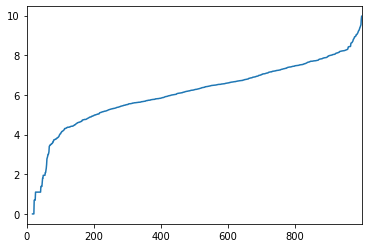

In [257]:
test_df['accumulated_actions'].map(np.log).sort_values().reset_index(drop=True).plot()

In [217]:
(test_df['type_Clip_count'] - test_df['changed_type_Clip_count']).mean()

8.562

In [209]:
test_df['event_data'].str.contains('"correct":false').sum()

28330

In [152]:
specs = pd.read_csv('./data/specs.csv')

In [192]:
import json

In [197]:
specs['args'].map(json.loads)[0]

[{'name': 'game_time',
  'type': 'int',
  'info': 'millisecond count since start of game'},
 {'name': 'round',
  'type': 'int',
  'info': 'number of the current round when the event takes place or 0 if no round'},
 {'name': 'level',
  'type': 'int',
  'info': 'number of the current level when the event takes place or 0 if no level'},
 {'name': 'description',
  'type': 'string',
  'info': 'the text or description of the instruction'},
 {'name': 'identifier',
  'type': 'string',
  'info': 'a unique identifier for this piece of instruction'},
 {'name': 'media_type',
  'type': 'string',
  'info': "the type of media that has just played:\n'audio' || 'animation' || 'other'"},
 {'name': 'duration',
  'type': 'int',
  'info': 'the duration of the media playback in milliseconds'},
 {'name': 'event_count', 'type': 'int', 'info': 'session event counter'},
 {'name': 'event_code', 'type': 'int', 'info': 'event class identifier'}]

In [ ]:
'misses', 'correct', 

In [191]:
specs['args'][specs['args'].map(lambda x: '"name":"misses","type":"int"' in x)] == specs['args'][specs['args'].map(lambda x: '"name":"misses"' in x)]

17     True
25     True
75     True
76     True
84     True
86     True
104    True
165    True
187    True
217    True
270    True
273    True
315    True
327    True
338    True
361    True
373    True
Name: args, dtype: bool

In [137]:
X = pd.read_csv('./data/preprocessed_train.csv')

In [151]:
X.drop(columns=['installation_id']).sum().sort_values().head(10)

title_event_code_Scrub-A-Dub_4080_count                       0.0
title_event_code_Sandcastle Builder (Activity)_2010_count     0.0
title_event_code_Crystals Rule_2010_count                     0.0
title_event_code_Bottle Filler (Activity)_2010_count          0.0
title_event_code_Air Show_4080_count                          0.0
title_event_code_Pan Balance_2010_count                       0.0
title_event_code_Dino Dive_4080_count                         5.0
title_event_code_Leaf Leader_4080_count                       8.0
title_event_code_Watering Hole (Activity)_2010_count         13.0
title_event_code_Happy Camel_4080_count                      15.0
dtype: float64

In [119]:
y.mean(), y.std()

(1.8855850763143018, 1.256796193579197)

In [438]:
with open('./checkpoints/model.pkl', 'rb') as fin:
        model = pickle.load(fin)
        
with open('./checkpoints/model_check.pkl', 'rb') as fin:
    model_check = pickle.load(fin)

In [116]:
np.abs((preds - check_preds)).sum()

4913

In [134]:
imps_std = np.std([m.feature_importance() for m in model.models], axis=0) / np.mean([m.feature_importance() for m in model.models], axis=0)

In [441]:
imps = np.sum([m.feature_importance() for m in model.models], axis=0) / 25

In [443]:
len(imps)

601

event_code_4045_count                                       12.04
title_event_code_Chicken Balancer (Activity)_4070_count     11.92
title_event_code_Bottle Filler (Activity)_3110_count        11.92
events_per_day                                              11.84
title_event_code_Magma Peak - Level 1_2000_count            11.80
                                                            ...  
Tree Top City - Level 3_title_total_time                     0.00
Welcome to Lost Lagoon!_title_total_time                     0.00
title_event_code_Crystals Rule_4090_count                    0.00
title_event_code_Bubble Bath_4080_count                      0.00
title_event_code_Mushroom Sorter (Assessment)_4080_count     0.00
Length: 450, dtype: float64

In [462]:
np.array(list(pd.Series(dict(zip(model.columns, imps))).sort_values(ascending=False).to_dict().keys()))[-450:]

array(['event_code_4045_count',
       'title_event_code_Chicken Balancer (Activity)_4070_count',
       'title_event_code_Bottle Filler (Activity)_3110_count',
       'events_per_day',
       'title_event_code_Magma Peak - Level 1_2000_count',
       'title_event_code_All Star Sorting_3021_count',
       'title_event_code_Chow Time_3120_count',
       'title_event_code_Bug Measurer (Activity)_3010_count',
       'last_accuracy_Cart Balancer (Assessment)',
       'title_event_code_Bottle Filler (Activity)_4035_count',
       'title_event_code_Pan Balance_4070_count',
       'Chicken Balancer (Activity)_title_total_time',
       'title_event_code_Happy Camel_4020_count',
       'title_event_code_Chow Time_3010_count',
       'title_event_code_Happy Camel_4030_count',
       'title_event_code_Dino Dive_2030_count', 'event_code_2060_count',
       'last_accuracy_Bird Measurer (Assessment)',
       'title_event_code_Bug Measurer (Activity)_4035_count',
       'title_event_code_Bottle Fille

In [125]:
dic = (pd.Series(dict(zip(model.columns, imps))).sort_values(ascending=False) / 8993.559999999998 * 100).map(lambda x: round(x, 5)).to_dict() 

In [126]:
std_dic = (pd.Series(dict(zip(model.columns, imps_std))).sort_values(ascending=False)).to_dict() 

In [127]:
new_dic = {}
for key in pd.Series(dict(zip(model.columns, imps_std))).sort_values(ascending=False).to_dict().keys():
    if 'event_code' in key and 'title' not in key:
        new_dic[key] = std_dic[key]

In [128]:
pd.Series(new_dic).sort_values()

event_code_3120_count    0.087152
event_code_3021_count    0.093816
event_code_4040_count    0.105094
event_code_2010_count    0.115862
event_code_4035_count    0.125621
event_code_4045_count    0.134668
event_code_4090_count    0.135656
event_code_3110_count    0.136163
event_code_4010_count    0.137043
event_code_2080_count    0.138547
event_code_4070_count    0.139294
event_code_3121_count    0.143835
event_code_3020_count    0.145101
event_code_2020_count    0.154594
event_code_2030_count    0.157978
event_code_4020_count    0.159170
event_code_3010_count    0.165013
event_code_4100_count    0.167211
event_code_2000_count    0.168023
event_code_4025_count    0.171174
event_code_4022_count    0.172389
event_code_2083_count    0.176805
event_code_2025_count    0.177704
event_code_4030_count    0.179230
event_code_4031_count    0.184721
event_code_4021_count    0.191651
event_code_4095_count    0.214669
event_code_2060_count    0.218025
dtype: float64

In [ ]:
['3121', '3021', '3020', '4070', '3120', '4030']

In [85]:
pd.Series(new_dic).sort_values()

event_code_3121_count    0.267939
event_code_3021_count    0.270873
event_code_3020_count    0.288969
event_code_4070_count    0.303314
event_code_3120_count    0.312569
event_code_4030_count    0.324362
event_code_4040_count    0.365735
event_code_2000_count    0.366034
event_code_4022_count    0.381013
event_code_2030_count    0.398913
event_code_4100_count    0.402813
event_code_4090_count    0.409772
event_code_4025_count    0.410391
event_code_4035_count    0.411412
event_code_4045_count    0.413040
event_code_2010_count    0.418926
event_code_4020_count    0.449024
event_code_2040_count    0.453147
event_code_4021_count    0.480686
event_code_2020_count    0.489266
event_code_4010_count    0.507844
event_code_3010_count    0.517064
event_code_2080_count    0.518424
event_code_2083_count    0.520449
event_code_3110_count    0.531357
event_code_4235_count    0.540295
event_code_4031_count    0.556500
event_code_5000_count    0.587226
event_code_5010_count    0.616697
event_code_202

In [56]:
pd.Series(new_dic).keys()

Index(['event_code_4070_count', 'event_code_4020_count',
       'event_code_3021_count', 'event_code_4030_count',
       'event_code_3121_count', 'event_code_3020_count',
       'event_code_2030_count', 'event_code_3120_count',
       'event_code_3010_count', 'event_code_3110_count',
       'event_code_4035_count', 'event_code_2000_count',
       'event_code_4025_count', 'event_code_4090_count',
       'event_code_2020_count', 'event_code_4040_count',
       'event_code_2010_count', 'event_code_4022_count',
       'event_code_4021_count', 'event_code_4100_count',
       'event_code_4010_count', 'event_code_2080_count',
       'event_code_4031_count', 'event_code_4045_count',
       'event_code_2060_count', 'event_code_2083_count',
       'event_code_2025_count', 'event_code_4095_count',
       'event_code_2040_count', 'event_code_5000_count',
       'event_code_4230_count', 'event_code_5010_count',
       'event_code_2035_count', 'event_code_4235_count',
       'event_code_2050_count',

In [16]:
train_df = pd.read_csv('../data/preprocessed_train.csv')

In [13]:
train_df['accuracy_group'].value_counts(normalize=True)

3    0.500000
0    0.239062
1    0.136292
2    0.124647
Name: accuracy_group, dtype: float64

In [17]:
train_df.columns.tolist()

['0_group_count',
 '1_group_count',
 '2_group_count',
 '3_group_count',
 'accumulated_accuracy',
 'accumulated_accuracy_group',
 'accumulated_actions',
 'accumulated_correct_attempts',
 'accumulated_sessions',
 'accumulated_uncorrect_attempts',
 'accuracy_group',
 'assess_duration_mean',
 'assess_duration_sum',
 'changed_type_Activity_count',
 'changed_type_Assessment_count',
 'changed_type_Clip_count',
 'changed_type_Game_count',
 'current_title_count',
 'current_title_total_time',
 'current_world_activity_time',
 'current_world_count',
 'current_world_game_time',
 'current_world_total_time',
 'day',
 'days_since_installation',
 'event_code_2000_count',
 'event_code_2010_count',
 'event_code_2020_count',
 'event_code_2025_count',
 'event_code_2030_count',
 'event_code_2035_count',
 'event_code_2040_count',
 'event_code_2050_count',
 'event_code_2060_count',
 'event_code_2070_count',
 'event_code_2075_count',
 'event_code_2080_count',
 'event_code_2081_count',
 'event_code_2083_count',

In [8]:
train_df['hour'].max()

23

In [55]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [96]:
(test['timestamp'][1000] - test['timestamp'][2]).days

12

array(['NONE', 'MAGMAPEAK', 'CRYSTALCAVES', 'TREETOPCITY'], dtype=object)

In [100]:
train_df['world'].unique()

array([3, 1, 0])

In [103]:
test['title'].nunique()

44

In [105]:
(test['title'] + test['type']).nunique()

44

In [85]:
test['timestamp']

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
...,...,...,...,...,...,...,...,...,...,...,...
1156409,c74f40cd,46ff9d3ad2be09f2,2019-09-28 21:20:40.918000+00:00,"{""description"":""Alright! This one is the littl...",ffe774cc,39,3121,32030,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156410,6c930e6e,46ff9d3ad2be09f2,2019-09-28 21:20:41.493000+00:00,"{""duration"":20008,""misses"":0,""event_count"":40,...",ffe774cc,40,2030,32584,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156411,a5be6304,46ff9d3ad2be09f2,2019-09-28 21:20:45.499000+00:00,"{""session_duration"":36607,""exit_type"":""game_co...",ffe774cc,41,2010,36607,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156412,27253bdc,96d7dc31e822cedc,2019-09-28 21:21:05.670000+00:00,"{""event_code"": 2000, ""event_count"": 1}",ffe774cc,1,2000,0,Tree Top City - Level 3,Clip,TREETOPCITY


In [84]:
(test['timestamp'].max() - test['timestamp'].min()).seconds

75369

In [7]:
train_df = pd.read_csv('../data/preprocessed_train.csv')
test_df = pd.read_csv('../data/preprocessed_test.csv')

In [44]:
assessments = ['Cart Balancer (Assessment)',
                   'Cauldron Filler (Assessment)',
                   'Chest Sorter (Assessment)',
                   'Mushroom Sorter (Assessment)',
                   'Bird Measurer (Assessment)']

In [51]:
test_df[['title_' + title +'_count' for title in assessments]].mean()

title_Cart Balancer (Assessment)_count      18.978
title_Cauldron Filler (Assessment)_count    23.211
title_Chest Sorter (Assessment)_count       17.767
title_Mushroom Sorter (Assessment)_count    21.718
title_Bird Measurer (Assessment)_count      19.953
dtype: float64

In [41]:
train_df['duration_mean'].mean()

174.582954571508

In [12]:
train_df['title'].value_counts(normalize=True)

8     0.234652
9     0.229226
30    0.212380
10    0.168513
4     0.155229
Name: title, dtype: float64

In [21]:
train_df.columns.tolist()

['0_group_count',
 '1_group_count',
 '2_group_count',
 '3_group_count',
 'Activity_count',
 'Assessment_count',
 'Clip_count',
 'Game_count',
 'acc_Bird Measurer (Assessment)',
 'acc_Cart Balancer (Assessment)',
 'acc_Cauldron Filler (Assessment)',
 'acc_Chest Sorter (Assessment)',
 'acc_Mushroom Sorter (Assessment)',
 'accumulated_accuracy',
 'accumulated_accuracy_group',
 'accumulated_actions',
 'accumulated_correct_attempts',
 'accumulated_uncorrect_attempts',
 'accuracy',
 'accuracy_group',
 'duration_mean',
 'event_code_2000_count',
 'event_code_2010_count',
 'event_code_2020_count',
 'event_code_2025_count',
 'event_code_2030_count',
 'event_code_2035_count',
 'event_code_2040_count',
 'event_code_2050_count',
 'event_code_2060_count',
 'event_code_2070_count',
 'event_code_2075_count',
 'event_code_2080_count',
 'event_code_2081_count',
 'event_code_2083_count',
 'event_code_3010_count',
 'event_code_3020_count',
 'event_code_3021_count',
 'event_code_3110_count',
 'event_code_3

In [4]:
count_cols = [col for col in train_df.columns if 'count' in col]

In [6]:
for col in count_cols:
    train_df[col] = train_df[col] / train_df['accumulated_actions']

In [3]:
train_df['accuracy_group'].value_counts(normalize=True)

3    0.500000
0    0.239062
1    0.136292
2    0.124647
Name: accuracy_group, dtype: float64

In [34]:
train_df.groupby('installation_id')['accumulated_actions'].sum().sort_values()

installation_id
08062502          0
9d570bf2          0
db2ab253          0
9b7d6baa          0
ad9d07d6          0
             ...   
96979008     745447
063e3e02     763717
08987c08    1026275
9f399a3a    1040058
f1c21eda    3560604
Name: accumulated_actions, Length: 3614, dtype: int64

In [45]:
train_df.groupby('installation_id')['0_group_count'].count().sort_values(ascending=False).head(10)

installation_id
08987c08    156
f1c21eda    129
9f399a3a     78
8e44d2de     72
123a40a1     64
96979008     64
416398f8     49
2ffb27f9     48
2d6d1ecd     47
063e3e02     46
Name: 0_group_count, dtype: int64

In [53]:
(train_df.groupby('installation_id')['0_group_count'].count().sort_values(ascending=True).head(10000) == 1).sum()

1027

In [38]:
train_df[train_df['installation_id'] != 'f1c21eda']

,0_group_count,1_group_count,2_group_count,3_group_count,Activity_count,Assessment_count,Clip_count,Game_count,acc_Bird Measurer (Assessment),acc_Cart Balancer (Assessment),...,title_event_code_Watering Hole (Activity)_3110_count,title_event_code_Watering Hole (Activity)_4020_count,title_event_code_Watering Hole (Activity)_4021_count,title_event_code_Watering Hole (Activity)_4025_count,title_event_code_Watering Hole (Activity)_4070_count,title_event_code_Watering Hole (Activity)_4090_count,title_event_code_Watering Hole (Activity)_5000_count,title_event_code_Watering Hole (Activity)_5010_count,title_event_code_Welcome to Lost Lagoon!_2000_count,world
0,0,0,0,0,3,0,6,2,-1.0,-1.0,...,0,0,0,0,0,0,0,0,2,3
1,0,0,0,1,4,1,8,4,-1.0,-1.0,...,0,0,0,0,0,0,0,0,2,3
2,1,0,0,1,4,2,8,4,0.0,-1.0,...,0,0,0,0,0,0,0,0,2,3
3,2,0,0,2,9,3,15,7,0.0,-1.0,...,5,9,8,9,4,0,5,5,3,3
4,2,0,1,2,10,3,17,9,0.0,-1.0,...,5,9,8,9,4,0,5,5,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17685,0,1,0,4,7,4,13,10,1.0,1.0,...,4,4,4,4,6,0,3,2,1,0
17686,0,0,0,0,2,0,2,2,-1.0,-1.0,...,0,0,0,0,0,0,0,0,1,1
17687,0,0,0,0,3,0,4,2,-1.0,-1.0,...,0,0,0,0,0,0,0,0,2,1
17688,0,1,0,0,3,1,7,4,-1.0,-1.0,...,0,0,0,0,0,0,0,0,3,3
